<a href="https://colab.research.google.com/github/quetion/time_series_11202/blob/main/TS_Ch4_%E9%A0%90%E6%B8%AC%E8%A1%A8%E7%8F%BE%E4%B9%8B%E8%A9%95%E4%BC%B0_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diebold-Mariano 檢定
- 以比特幣報酬為例
- 比較AR(1)與AR(2)的模型預測能力
- 利用Diebold-Mariano 檢定

In [1]:
# package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
#from statsmodels.regression.rolling import RollingOLS

In [2]:
data = yf.download('BTC-USD',start = '2022-01-01',end='2024-04-23')
data = data[['Adj Close']]
data.columns = ['price_btc']

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.index = pd.to_datetime(data.index)

In [4]:
data.head()

,price_btc
Date,
2022-01-01,47686.812500
2022-01-02,47345.218750
2022-01-03,46458.117188
2022-01-04,45897.574219
2022-01-05,43569.003906


<Axes: xlabel='Date'>

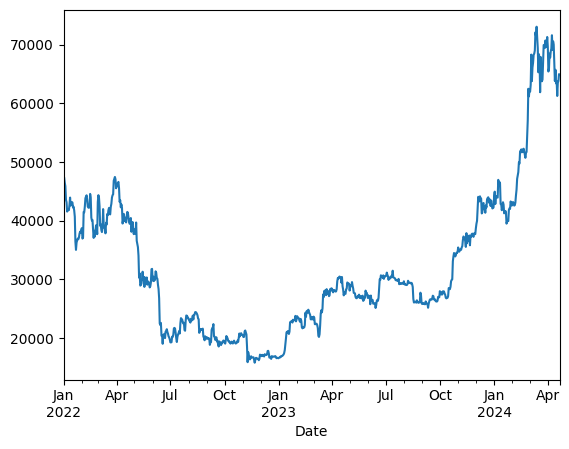

In [8]:
data.price_btc.plot()

## 設定自變數
- 報酬率
- 落後一期報酬率
- 落後二期報酬率

In [ ]:
data['ret'] = np.log(data.btcusd).diff()
data['ret_1'] = data.ret.shift(1)
data['ret_2'] = data.ret.shift(2)

In [ ]:
data.head()

,btcusd,ret,ret_1,ret_2
Date,,,,
2017-12-31,14156.400391,NaN,NaN,NaN
2018-01-01,13657.200195,-0.035900,NaN,NaN
2018-01-02,14982.099609,0.092589,-0.035900,NaN
2018-01-03,15201.000000,0.014505,0.092589,-0.035900
2018-01-04,15599.200195,0.025858,0.014505,0.092589


## 設定樣本範圍
- 資料總數為`1190`
- 樣本內資料設定為`R=200`
- 樣本外資料設定為`P=990`


In [ ]:
R = 200
P = len(data) - R
print(R,P)


200 999


In [ ]:
y = data.ret[0:200]
y

Date
2017-12-31         NaN
2018-01-01   -0.035900
2018-01-02    0.092589
2018-01-03    0.014505
2018-01-04    0.025858
                ...   
2018-07-13    0.006084
2018-07-14    0.013220
2018-07-15    0.058348
2018-07-16    0.082433
2018-07-17    0.006771
Name: ret, Length: 200, dtype: float64

In [ ]:
# out-of-sample MSE
R = 200
P = len(data) - R
print(R,P)
#
e1 = np.zeros(P)
e2 = np.zeros(P)
for i in range(1,P-1):
    y = data.ret[i:R+i]
    x = sm.add_constant(data.ret_1[i:R+i])
    result_ar1 = sm.OLS(y,x,missing='drop').fit()
    x = sm.add_constant(data[['ret_1','ret_2']][i:R+i])
    result_ar2 = sm.OLS(y,x,missing='drop').fit()
    fitted_ar1 = result_ar1.params[0] + result_ar1.params[1]*data.ret_1[R+i-1]
    fitted_ar2 = result_ar2.params[0] + result_ar2.params[1]*data.ret_1[R+i-1] + result_ar2.params[2]*data.ret_2[R+i-1]
    e1[i] = data.ret[R+i] - fitted_ar1
    e2[i] = data.ret[R+i] - fitted_ar2
mse_ar1_oos = np.mean(e1**2)
mse_ar2_oos = np.mean(e2**2)

200 999


In [ ]:
print(mse_ar1_oos,mse_ar2_oos)
y = e1**2 - e2**2
x = np.ones(len(y))
# 利用 Newey-West標準誤估計
rr = sm.OLS(y,x,missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(rr.summary())

0.0014881472016738278 0.0015112931325377834
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                nan
Time:                        12:39:38   Log-Likelihood:                 6769.6
No. Observations:                 999   AIC:                        -1.354e+04
Df Residuals:                     998   BIC:                        -1.353e+04
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### 判斷模型好壞
- MSE 直接比大小
- 檢定: pvalue

In [ ]:
rr.pvalues

array([0.0815414])